## Computer Vision

1. Face Recognition:
Use CV to recognize faces for user's logins validation.

2. Image Similarity Search:
Use CV to search images with other image as query and find similar images.

## Face Recognition

In [1]:
from facenet_pytorch import InceptionResnetV1
import torch
import PIL
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mtcnn import MTCNN
from utils.computer_vision import FaceDataset, plot_images_horizontal
from torch.utils.data import DataLoader
from qdrant_client import QdrantClient
from qdrant_client.http import models

/home/josealcocer27/.cache/pypoetry/virtualenvs/pycon-colombia-2024-rDJfgf35-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-30 22:47:15.581094: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 22:47:17.455001: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


GPU agnostic

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device 

'cpu'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


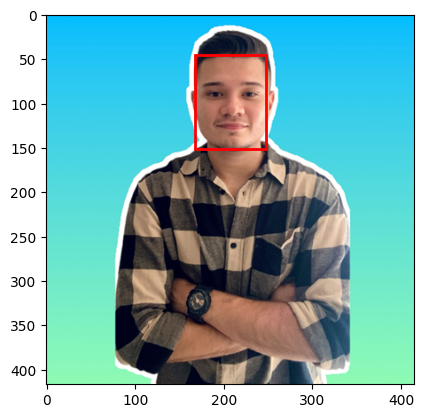

In [28]:
# Load and image
img = PIL.Image.open("../assets/examples/me.png").convert(mode="RGB")

# Convert it to array
img = np.array(img)

# Create mtcc object
detector = MTCNN(min_face_size=30)

# Detect faces
resultados = detector.detect_faces(img)

# Plots
fig, ax = plt.subplots()
ax.imshow(img)
for resultado in resultados:
    x, y, w, h = resultado['box']
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.show()


Let's use MTCNN tools from facenet_pytorch and crop the face 

In [4]:
del MTCNN
from facenet_pytorch import MTCNN

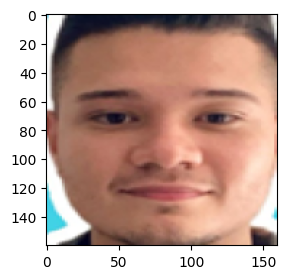

In [5]:
mtcnn = MTCNN(image_size=160, margin=5, min_face_size=35, post_process=False)
cropped_img = mtcnn(img).permute(1, 2, 0).int().numpy()
plt.figure(figsize=(3,3))
plt.imshow(cropped_img)
plt.show()

Let's compute a Embedding

In [6]:
mtcnn_detector = MTCNN(image_size=160, margin=5, min_face_size=35, post_process=True)
resnet = InceptionResnetV1(pretrained="vggface2", classify=False, device = device).eval()
cropped_img = mtcnn_detector(img).unsqueeze(0)
embedding = resnet(cropped_img)
print(f"Our embedding has a dimension of {embedding.shape[1]}")

Our embedding has a dimension of 512


Let's create our FaceDataset

In [12]:
ds = FaceDataset(root_dir="../data/unstructured/imgs")
dataloader = DataLoader(ds, batch_size=4, shuffle=True)

Plot some images

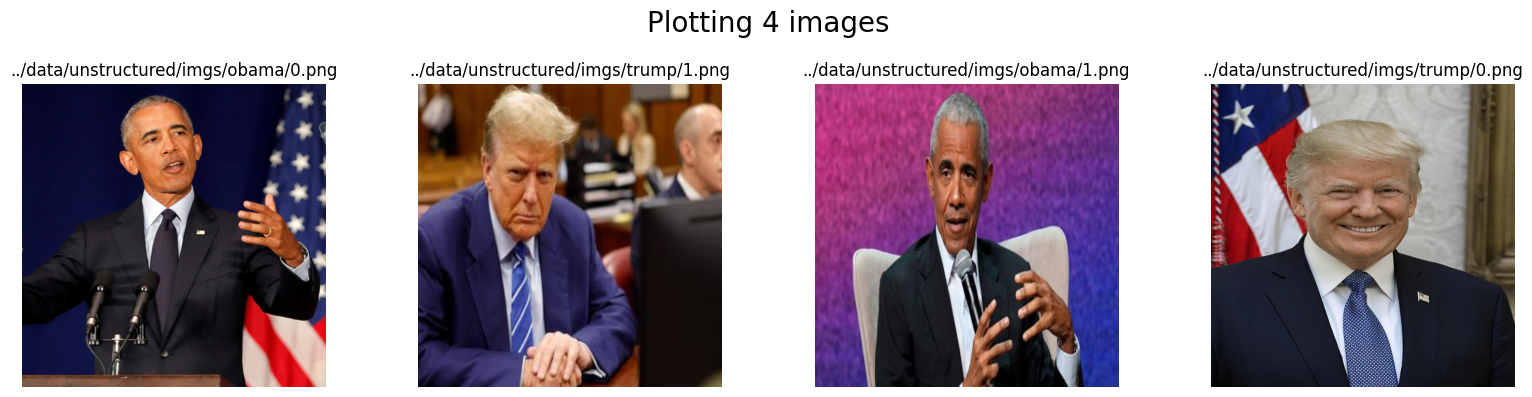

In [8]:
test_imgs, labels_imgs = next(iter(dataloader))
test_imgs = [np.array(img) for img in test_imgs]
plot_images_horizontal(test_imgs, labels_imgs)

Process the dataset by batch detecting faces and computing embeddings 

In [13]:
embeddings = []
used = []
with torch.no_grad():
    for run, (batch, idxs) in enumerate(dataloader):
        print (f"Batch # {run+1} of size {dataloader.batch_size}")
        to_use = []
        batch_images = []
        not_used = []
        for idx, img in enumerate (batch):
            detected_face, prob = mtcnn_detector(img, return_prob=True)
            if prob is not None:
                batch_images.append(detected_face.to(device))
                used.append(idxs[idx])
            else:
                not_used.append(idxs[idx])

        if len (batch_images) > 0:
            embedding = resnet(torch.stack(batch_images)).to("cpu")
            used.extend(to_use)
            embeddings.append(embedding)

            del batch_images, to_use, detected_face, embedding
            torch.cuda.empty_cache()

Batch # 1 of size 4s
Batch # 2 of size 4s


Persists embeddings and labels

In [20]:
data = [torch.cat(embeddings, dim=0), used]
torch.save(data, "../data/unstructured/imgs_embeddings/data.pt")

Create client

In [2]:
client = QdrantClient(host="localhost", port=6333)

Recreate collection

In [43]:
my_collection = "face_embeddings2"
client.recreate_collection(
    collection_name=my_collection,
    vectors_config=models.VectorParams(size=512, distance=models.Distance.COSINE)
)

True

Upsert records

In [66]:
client.upsert(
    collection_name=my_collection,
    points=models.Batch(
        ids=[i for i in range(len(used))],
        vectors=torch.cat(embeddings, dim=0).tolist(),
        payloads = [{"path": path[1:]} for path in used]
    )
)

UpdateResult(operation_id=1, status=<UpdateStatus.COMPLETED: 'completed'>)

Test with an image

In [49]:
import PIL.Image

test = PIL.Image.open("../assets/examples/obama_test.png")
test = test.convert(mode="RGB")

Compute embeddings

In [67]:
detected_face, prob = mtcnn_detector(test, return_prob=True)
embedding = resnet(detected_face.unsqueeze(0))

Search into collection

In [68]:
client.search(
    collection_name=my_collection,
    query_vector=embedding.detach().cpu().numpy().tolist()[0],
    score_threshold=0.6,
    limit=10
)

[ScoredPoint(id=4, version=1, score=0.69455683, payload={'path': './data/unstructured/imgs/obama/2.png'}, vector=None, shard_key=None),
 ScoredPoint(id=3, version=1, score=0.6854315, payload={'path': './data/unstructured/imgs/obama/0.png'}, vector=None, shard_key=None),
 ScoredPoint(id=1, version=1, score=0.632252, payload={'path': './data/unstructured/imgs/obama/1.png'}, vector=None, shard_key=None)]

## Product's Images Similarity Search

Load model for Feature Extraction and Image Processor

In [1]:
from transformers import ViTImageProcessor, ViTModel

model_id = 'jolual2747/vit-clothes-classification'
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = ViTImageProcessor.from_pretrained(model_id)
model = ViTModel.from_pretrained(model_id, force_download = True)
model = model.to(device)

/home/josealcocer27/.cache/pypoetry/virtualenvs/pycon-colombia-2024-rDJfgf35-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-29 01:16:47.559996: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 01:16:49.328000: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Some weights of ViTModel were not initialized from the model checkpoint at jolual2747/vit-clothes-classification and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream

In [10]:
model.save_pretrained("../assets/embedding_model")

Load Dataset and download images from URLs

In [2]:
from datasets import load_dataset
from utils.computer_vision import fetch_images

num_threads = 20
dset = load_dataset('DBQ/Matches.Fashion.Product.prices.France', download_mode="force_redownload")
dset = dset.shuffle(42)["train"].select(range(100))
dset = dset.map(fetch_images, batched=True, batch_size=20, fn_kwargs={"num_threads": num_threads})

Map: 100%|██████████| 100/100 [00:04<00:00, 21.47 examples/s]


Preprocess images

In [19]:
def preprocess_image(batch: dict):
    images = [image for image in batch["image"]]
    inputs = processor(images=images, return_tensors="pt")
    return inputs

dset = dset.map(preprocess_image, batched=True, batch_size=8)   

Map: 100%|██████████| 100/100 [00:01<00:00, 51.90 examples/s]


In [15]:
import PIL
import torch
image = PIL.Image.open("../assets/examples/jewelry.png")
#image = dset[0]["image"]

inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)


In [16]:
embedding = outputs.pooler_output
embedding.mean()

tensor(0.0022)

Compute embeddings

In [21]:
def create_embeddings(batch: dict):
    pixel_values = torch.stack([torch.tensor(b) for b in batch["pixel_values"]])
    inputs = {"pixel_values": pixel_values}
    outputs = model(**inputs)
    last_hidden_states = outputs.pooler_output
    return {"pooler_output": last_hidden_states}

with torch.no_grad():
    dset = dset.map(create_embeddings, batched=True, batch_size=10)

Map: 100%|██████████| 100/100 [00:38<00:00,  2.58 examples/s]


Get Pandas DataFrame and generate payload for Qdrant

In [22]:
ds_pandas = dset.to_pandas()
ds_pandas["id"] = np.array([i for i in range(ds_pandas.shape[0])])
payload = ds_pandas[["id", "title", "category3_code"]].to_dict(orient="records")

In [3]:
import pandas as pd
from ast import literal_eval

df = pd.read_csv("../data/structured/products.csv")
df["image"] = df["image"].apply(literal_eval)
df["pooler_output"] = df["pooler_output"].apply(literal_eval)

In [5]:
ds_pandas = df.copy()
payload = ds_pandas[["id", "title", "category3_code"]].to_dict(orient="records")

In [23]:
ds_pandas[["id", "category2_code", "title", "category3_code", "image"]].to_csv("../data/structured/products.csv", index = None)

Create client

In [6]:
client = QdrantClient(host="localhost", port=6333)

Create collection

In [7]:
my_collection = "products2"
client.recreate_collection(
    collection_name=my_collection,
    vectors_config=models.VectorParams(size=768, distance=models.Distance.COSINE)
)

True

Insert records

In [8]:
from tqdm.auto import tqdm

batch_size = 64

for i in tqdm(range(0, len(ds_pandas), batch_size)):

  # find end of batch
  i_end = min(i + batch_size, len(ds_pandas))

  # extract batch
  batch = ds_pandas.iloc[i:i_end]

  # generate embeddings for batch
  payloads = batch[["id", "category2_code", "title", "category3_code"]].to_dict(orient="records")

  # upsert/insert these records
  client.upsert(
      collection_name=my_collection,
      points=models.Batch(
          ids=batch["id"],
          vectors=batch["pooler_output"],
          payloads = payloads
      )
  )

100%|██████████| 79/79 [00:05<00:00, 15.32it/s]


Let's test it 😎!

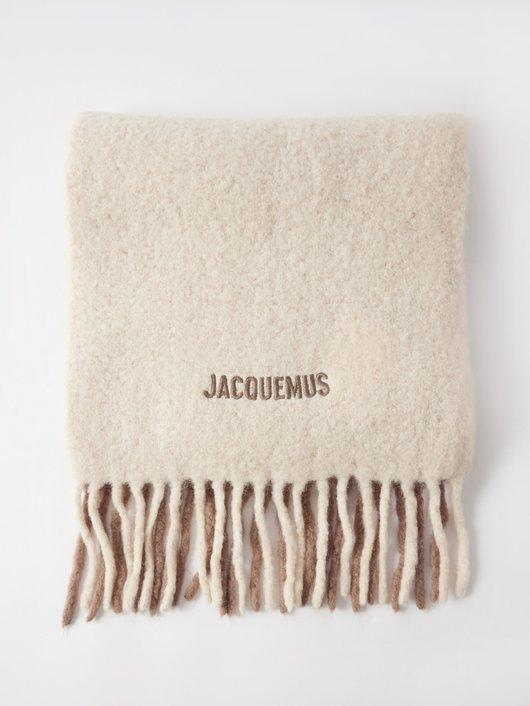

In [24]:
image = PIL.Image.open("../assets/examples/scarf.png")
image

In [17]:
model = ViTModel.from_pretrained("../assets/embedding_model")

In [25]:
inputs = processor(images=image, return_tensors="pt")
inputs = inputs.to(device)

with torch.no_grad():
    outputs = model(**inputs)
    embedding = outputs.pooler_output

In [28]:
results = client.search(
    collection_name=my_collection,
    query_vector=embedding.detach().cpu().numpy().tolist()[0],
    score_threshold = 0.6,
    limit=10,
    with_vectors=True
)

In [29]:
res = [result.id for result in results]
res

[20, 3647, 1501, 383, 4210, 2697, 3306, 2120, 3822, 3444]

In [30]:
results[:2]

[ScoredPoint(id=20, version=0, score=1.0, payload={'category2_code': 'ACCESSORIES', 'category3_code': 'SCARVES', 'id': 20, 'title': 'Moisson fringed ombré alpaca-blend scarf'}, vector=[0.052232467, -0.010353509, 0.024706855, -0.039224856, -0.002940928, 0.009114634, -0.0050104717, -0.0013608437, 0.047715038, -0.06635231, 0.049681596, -0.02205432, -0.019289121, 0.019444007, -0.017902989, 0.019285616, 0.017342955, -0.031183071, -0.004293928, 0.04722097, 0.027686749, 0.032181583, 0.020732025, -0.020438677, -0.0014913233, 0.03607298, 0.020987097, -0.037625406, 0.017512305, -0.03598885, 0.030297428, 0.08157691, 0.015231222, 0.024954297, -0.00084137474, 0.029548544, -0.039328925, -0.048929784, 0.015664622, -0.0043115034, 0.0246886, 0.034460753, 0.024438739, 0.0074040336, 0.03838375, -0.010182903, 5.146632e-05, 0.03550542, -0.013696001, 0.024130711, 0.010514293, 0.04530519, 0.07171986, -0.06844451, -0.013512137, -0.043015875, 0.010061216, 0.024546318, 0.0008133422, 0.015637869, -0.06366758, -0

In [31]:
from io import BytesIO
images = []
for row in ds_pandas.iloc[res,]["image"]:
    images.append(np.array(PIL.Image.open(BytesIO(row["bytes"]))))

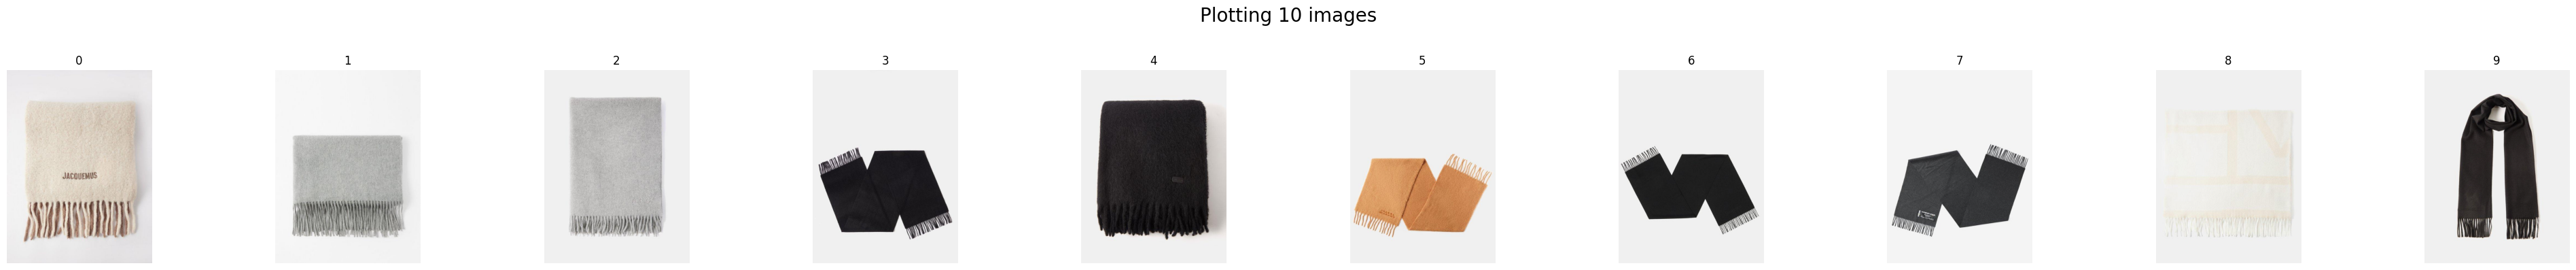

In [32]:
plot_images_horizontal(images, titles=[str(i) for i in range(len(images))])

In [44]:
ds_pandas.iloc[3]

,id,category2_code,title,category3_code,image,pooler_output
0,0,ACCESSORIES,Lotus 24kt gold-plated clip earrings,FASHION JEWELRY,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"[-0.1462753564119339, -0.0585092268884182, 0.1..."
1,1,ACCESSORIES,Gemmy Gem tourmaline & 18kt rose-gold necklace,FINE JEWELRY,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"[-0.052323948591947556, -0.04761943593621254, ..."
2,2,ACCESSORIES,The Rocky Road 24kt gold-plated bracelet,FASHION JEWELRY,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"[-0.11858505755662918, -0.05422288551926613, 0..."
3,3,CLOTHING,Hooded nylon-blend parka,COATS,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"[0.12936364114284515, 0.045448966324329376, 0...."
4,4,HOMEWARE,Set of four hand-painted ceramic dinner plates,TABLETOP,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"[-0.05885414406657219, -0.09165752679109573, 0..."
...,...,...,...,...,...,...
4995,4995,CLOTHING,Cotton-twill trucker jacket,JACKETS,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"[0.13351592421531677, 0.08910518139600754, 0.1..."
4996,4996,CLOTHING,Paita high-rise silk wrap maxi skirt,SKIRTS,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"[0.03077179752290249, -0.04755176976323128, -0..."
4997,4997,ACCESSORIES,Plate logo-engraved corded bracelet,FASHION JEWELRY,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"[0.025696255266666412, 0.07098249346017838, -0..."
4998,4998,CLOTHING,Space-dyed cotton-piqué polo shirt,POLO SHIRTS,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"[-0.11802656948566437, 0.0272323340177536, 0.0..."


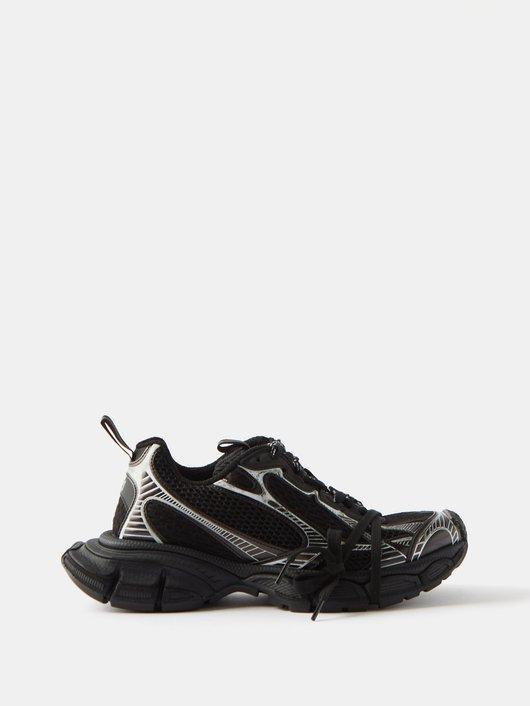

In [60]:
PIL.Image.open(BytesIO(ds_pandas.iloc[54]["image"]["bytes"]))

In [53]:
ds_pandas.iloc[250]

id                                                              250
category2_code                                          ACCESSORIES
title                                    Grenoble logo-patch beanie
category3_code                                                 HATS
image             {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
pooler_output     [-0.2006104588508606, 0.16122519969940186, 0.1...
Name: 250, dtype: object

In [61]:
from io import BytesIO
PIL.Image.open(BytesIO(ds_pandas.iloc[54]["image"]["bytes"])).save("../assets/examples/shoes.png")